In [1]:
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv('training_set_rel3.tsv', sep='\t', encoding="latin1")
df['essay'] = df['essay'].fillna('')

# Keep relevant columns
df = df[['essay_id', 'essay_set', 'essay', 'domain1_score']]

# Display basic info
print(df.shape)
print(df.head())

(12976, 4)
   essay_id  essay_set                                              essay  \
0         1          1  Dear local newspaper, I think effects computer...   
1         2          1  Dear @CAPS1 @CAPS2, I believe that using compu...   
2         3          1  Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...   
3         4          1  Dear Local Newspaper, @CAPS1 I have found that...   
4         5          1  Dear @LOCATION1, I know having computers has a...   

   domain1_score  
0              8  
1              9  
2              7  
3             10  
4              8  


In [2]:
# Remove illegible or corrupted essays
df = df[~df['essay'].str.contains('illegible|\\?\\?\\?', case=False, na=False)]

# Drop any rows with missing text or scores
df = df.dropna(subset=['essay', 'domain1_score']).reset_index(drop=True)
print(f"After cleaning, dataset shape: {df.shape}")

After cleaning, dataset shape: (12703, 4)


In [3]:
# Check score ranges per essay set
for s in sorted(df['essay_set'].unique()):
    min_score = df[df['essay_set'] == s]['domain1_score'].min()
    max_score = df[df['essay_set'] == s]['domain1_score'].max()
    print(f"Set {s}: min={min_score}, max={max_score}")

print("=" *50)    

# Scale scores to 0-1 range per essay set
df['score_scaled'] = df.apply(
    lambda x: (x['domain1_score'] - df[df['essay_set'] == x['essay_set']]['domain1_score'].min()) /
              (df[df['essay_set'] == x['essay_set']]['domain1_score'].max() -
               df[df['essay_set'] == x['essay_set']]['domain1_score'].min()),
    axis=1
)
print(df[['essay_set', 'domain1_score', 'score_scaled']].head())

Set 1: min=2, max=12
Set 2: min=1, max=6
Set 3: min=0, max=3
Set 4: min=0, max=3
Set 5: min=0, max=4
Set 6: min=0, max=4
Set 7: min=2, max=24
Set 8: min=10, max=60
   essay_set  domain1_score  score_scaled
0          1              8           0.6
1          1              9           0.7
2          1              7           0.5
3          1             10           0.8
4          1              8           0.6


In [4]:
import re

def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # remove HTML
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # remove special chars
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra spaces
    return text

df['essay'] = df['essay'].apply(clean_text)


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

# TF-IDF features (unigrams + bigrams)
vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 3),
    
)
X_tfidf = vectorizer.fit_transform(df['essay'])

# Simple numeric features
df['essay_len'] = df['essay'].apply(len)
df['word_count'] = df['essay'].apply(lambda x: len(x.split()))
df['avg_word_len'] = df['essay'].apply(lambda x: np.mean([len(w) for w in x.split()]) if len(x.split()) > 0 else 0)

numeric_features = df[['essay_len', 'word_count', 'avg_word_len']].values

# Combine TF-IDF + numeric
from scipy.sparse import csr_matrix
X = hstack([X_tfidf, csr_matrix(numeric_features)])
y = df['score_scaled'].values

print(f"Final feature matrix shape: {X.shape}")



Final feature matrix shape: (12703, 10003)


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}")


Train shape: (10162, 10003), Validation shape: (2541, 10003)


In [8]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, cohen_kappa_score
from scipy.stats import pearsonr
import numpy as np

# Train Ridge Regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

# Predict on validation set
y_pred = ridge.predict(X_val)

# Calculate metrics
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)
pearson_corr, _ = pearsonr(y_pred, y_val)

# Rescale predictions and labels for QWK
score_ranges = {
    1: (2, 12), 2: (1, 6), 3: (0, 3), 4: (0, 3),
    5: (0, 4), 6: (0, 4), 7: (2, 24), 8: (10, 60)
}

def rescale(scaled, essay_sets):
    original = []
    for val, s in zip(scaled, essay_sets):
        min_score, max_score = score_ranges[s]
        orig = val * (max_score - min_score) + min_score
        original.append(round(orig))
    return np.array(original)

# Get essay_set for each validation sample
val_essay_sets = df.iloc[X_val.indices]['essay_set'].values if hasattr(X_val, 'indices') else df.iloc[X_val.nonzero()[0]]['essay_set'].values

y_pred_orig = rescale(y_pred, val_essay_sets)
y_val_orig = rescale(y_val, val_essay_sets)

# Calculate QWK
qwk = cohen_kappa_score(y_val_orig, y_pred_orig, weights='quadratic')


print("=" * 50)
print("📊 MODEL PERFORMANCE METRICS         RIDGE"    )
print("=" * 50)
print(f"Quadratic Weighted Kappa (QWK):     {qwk:.4f}")
print(f"Pearson Correlation:                {pearson_corr:.4f}")
print(f"R² Score:                           {r2:.4f}")
print(f"Mean Absolute Error (MAE):          {mae:.4f}")
print(f"Root Mean Squared Error (RMSE):     {rmse:.4f}")
print("=" * 50)

📊 MODEL PERFORMANCE METRICS         RIDGE
Quadratic Weighted Kappa (QWK):     0.9240
Pearson Correlation:                0.7327
R² Score:                           0.5369
Mean Absolute Error (MAE):          0.1262
Root Mean Squared Error (RMSE):     0.1629


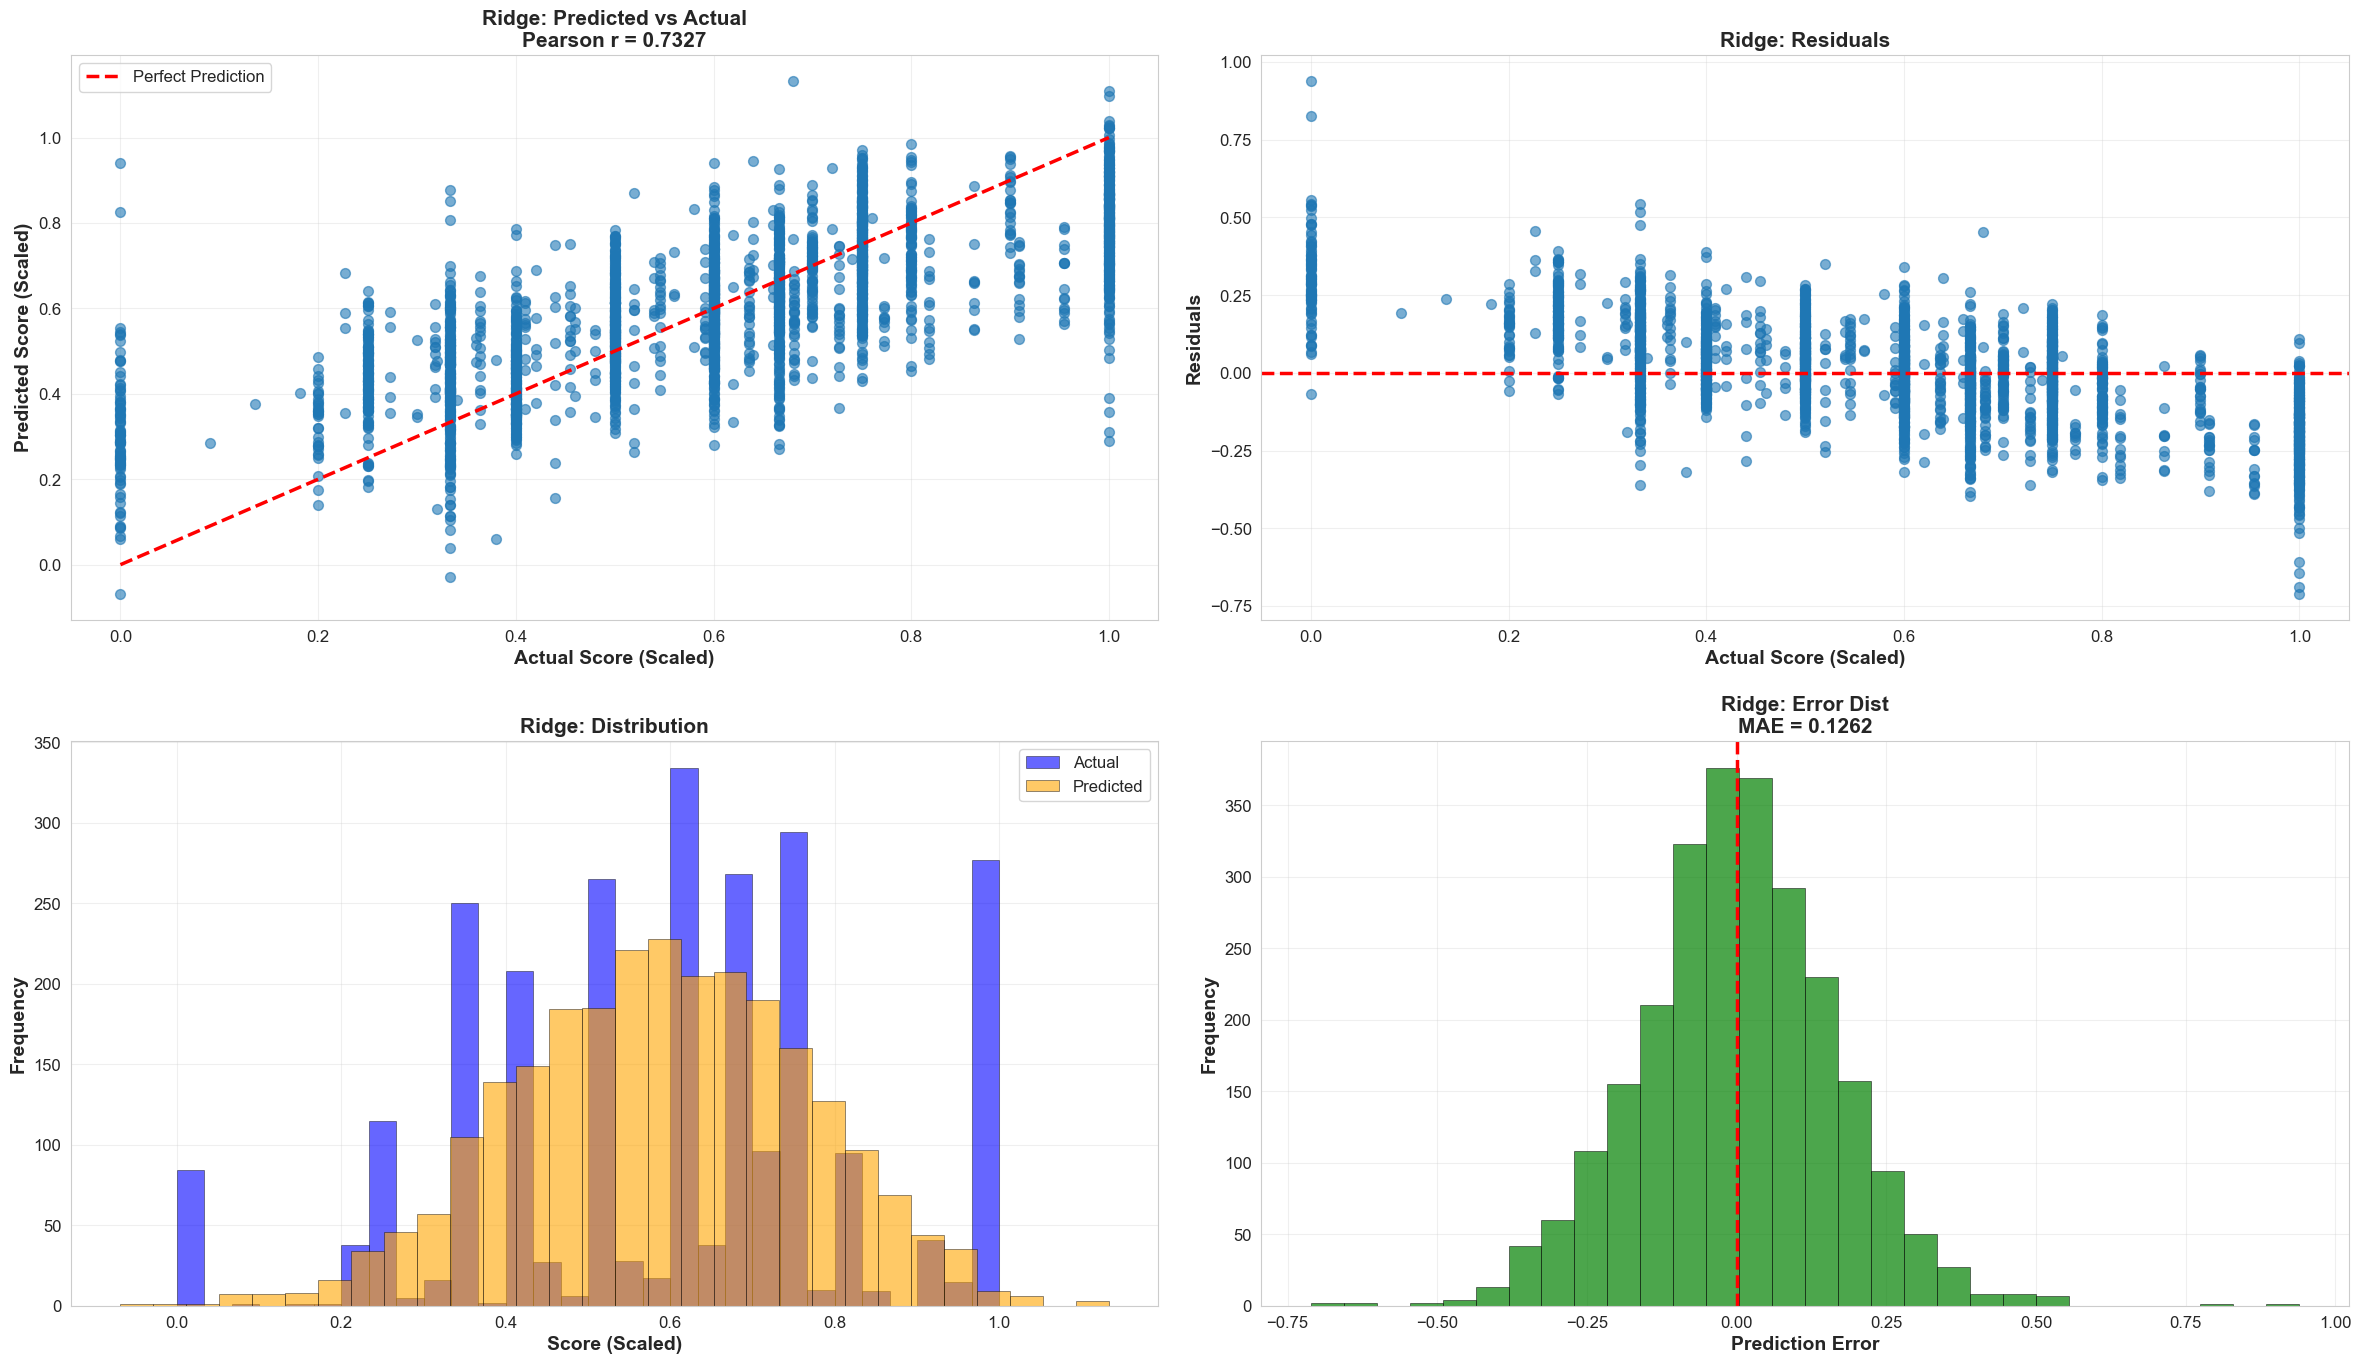

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# ...existing code...
fig, axes = plt.subplots(2, 2, figsize=(24, 14))

# 1. Scatter Plot: Predicted vs Actual (Scaled) - Ridge
axes[0, 0].scatter(y_val, y_pred, alpha=alpha_val, s=marker_size)
axes[0, 0].plot([0, 1], [0, 1], 'r--', lw=2.5, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual Score (Scaled)', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Predicted Score (Scaled)', fontsize=14, fontweight='bold')
axes[0, 0].set_title(f'Ridge: Predicted vs Actual\nPearson r = {pearson_corr:.4f}', fontsize=15, fontweight='bold')
axes[0, 0].legend(fontsize=12)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(labelsize=12)

# 2. Residual Plot - Ridge
residuals_ridge = y_pred - y_val
axes[0, 1].scatter(y_val, residuals_ridge, alpha=alpha_val, s=marker_size)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2.5)
axes[0, 1].set_xlabel('Actual Score (Scaled)', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Residuals', fontsize=14, fontweight='bold')
axes[0, 1].set_title('Ridge: Residuals', fontsize=15, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].tick_params(labelsize=12)

# 3. Distribution of Predictions vs Actual - Ridge
axes[1, 0].hist(y_val, bins=30, alpha=0.6, label='Actual', color='blue', edgecolor='black', linewidth=0.5)
axes[1, 0].hist(y_pred, bins=30, alpha=0.6, label='Predicted', color='orange', edgecolor='black', linewidth=0.5)
axes[1, 0].set_xlabel('Score (Scaled)', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Frequency', fontsize=14, fontweight='bold')
axes[1, 0].set_title('Ridge: Distribution', fontsize=15, fontweight='bold')
axes[1, 0].legend(fontsize=12)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].tick_params(labelsize=12)

# 4. Error Distribution - Ridge
axes[1, 1].hist(residuals_ridge, bins=30, color='green', alpha=0.7, edgecolor='black', linewidth=0.5)
axes[1, 1].axvline(x=0, color='r', linestyle='--', lw=2.5)
axes[1, 1].set_xlabel('Prediction Error', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Frequency', fontsize=14, fontweight='bold')
axes[1, 1].set_title(f'Ridge: Error Dist\nMAE = {mae:.4f}', fontsize=15, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].tick_params(labelsize=12)

plt.tight_layout(pad=2.0)
plt.savefig('ridge_vals.png', dpi=400, bbox_inches='tight')
plt.show()



In [12]:
def predict_essay_score_ridge(essay_text, essay_set, vectorizer, ridge_model, score_ranges):
    # Clean and vectorize essay
    essay_clean = clean_text(essay_text)
    X_tfidf = vectorizer.transform([essay_clean])
    # Add numeric features
    essay_len = len(essay_clean)
    word_count = len(essay_clean.split())
    avg_word_len = np.mean([len(w) for w in essay_clean.split()]) if word_count > 0 else 0
    numeric = np.array([[essay_len, word_count, avg_word_len]])
    from scipy.sparse import hstack, csr_matrix
    X = hstack([X_tfidf, csr_matrix(numeric)])
    # Predict
    score_scaled = ridge_model.predict(X)[0]
    min_score, max_score = score_ranges[essay_set]
    score_orig = score_scaled * (max_score - min_score) + min_score
    return round(score_orig, 2)

In [13]:
# Example usage
score_ranges = {
    1: (0, 10), 2: (1, 6), 3: (0, 3), 4: (0, 3),
    5: (0, 4), 6: (0, 4), 7: (2, 24), 8: (10, 60)
}
essay = """Ai is very good for teaching.
Ai is very good for teaching.
Ai is very good for teaching.
Ai is very good for teaching.
Ai is very good for teaching.
Ai is very good for teaching.
Ai is very good for teaching.
Ai is very good for teaching.
Ai is very good for teaching.
Ai is very good for teaching.
Ai is very good for teaching.
Ai is very good for teaching.
"""

essay_set =1  # Change as needed

predicted_score = predict_essay_score_ridge(essay, essay_set, vectorizer, ridge, score_ranges)

print("Predicted score:", predicted_score)

Predicted score: 1.95
